## Demonstration of scNiche on the human triple-negative breast cancer (TNBC) MIBI-TOF data

In this tutorial, we will show you the downstream analytical framework of scNiche for r characterizing the identified cell niches more comprehensively.

The [human TNBC MIBI-TOF dataset (*Cell, 2018*)](https://doi.org/10.1016/j.cell.2018.08.039) from 19 mixed subtype samples and 15 compartmentalized subtype samples contains a total of 173,205 cells, and the cell niches have been identified by scNiche.


### Import modules

In [1]:
import scniche as sn
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scniche.pl import *
import warnings
warnings.filterwarnings('ignore')

print("Last run with scNiche version:", sn.__version__)

# set seed
sn.pp.set_seed()

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Last run with scNiche version: 1.0.0


### Load data

We can download the dataset from figshare, and load it by the `read_h5ad()` function of `scanpy`, or directly download and load the dataset by the `human_tnbc_mibi_tof()` of `scniche`

In [2]:
# download data from figshare (https://figshare.com/ndownloader/files/47153020)
# adata = sn.datasets.human_tnbc_mibi_tof()
adata = sc.read_h5ad('tnbc.h5ad.gz')
adata

AnnData object with n_obs × n_vars = 173205 × 36
    obs: 'SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P', 'Ca', 'Fe', 'Background', 'B7H3', 'OX40', 'CD163', 'CSF.1R', 'Ta', 'Au', 'tumorYN', 'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup', 'group_name', 'immuneGroup_name', 'all_group_name', 'leiden', 'x', 'y', 'scNiche', 'subtype', 'all_group_name2'
    obsm: 'X_cn', 'X_cn_norm', 'X_data', 'X_data_nbr', 'X_pca', 'X_scniche', 'spatial'

### Some visualizations

Visualizing the cellular composition of each cell niche by the `stacked_barplot()` function of `scniche`

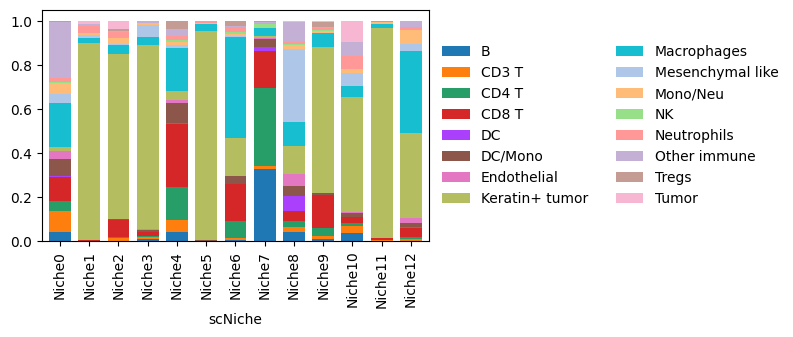

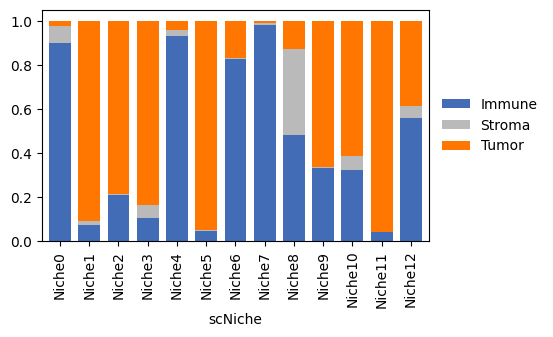

In [3]:
kwargs = {'figsize': (5, 3)}
sn.pl.stacked_barplot(adata, x_axis='scNiche', y_axis='all_group_name', mode='proportion', palette=palettes.default_20, kwargs=kwargs)
sn.pl.stacked_barplot(adata, x_axis='scNiche', y_axis='all_group_name2', mode='proportion', palette=['#426cb5', '#bababa', '#ff7700'], kwargs=kwargs)

Visualizing the spatial distribution of cell populations or cell niches for each slice

[<AxesSubplot: title={'center': 'all_group_name'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'scNiche'}, xlabel='spatial1', ylabel='spatial2'>]

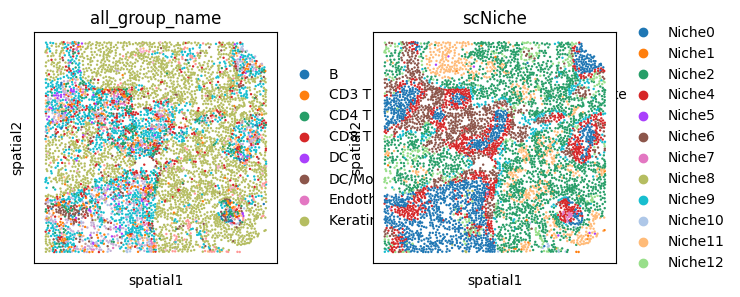

In [4]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['SampleID'] == 9], basis="spatial", color=['all_group_name', 'scNiche', ],s=12, show=False)

`scniche` provides the neighborhood composition information of each cell, stored in `adata.obsm['X_cn_norm']`. We can extract this information and visualize
it by the `embedding` function of `scanpy`. For example, we found that the two spatially adjacent cell niches, Niche 4 and Niche 0,
were enriched with lymphoid immune cells (such as CD4 T cells) and other immune cells, respectively,
which may reflect the diversity of the immune responses to tumors.


[<AxesSubplot: title={'center': 'CD4 T'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'Other immune'}, xlabel='spatial1', ylabel='spatial2'>]

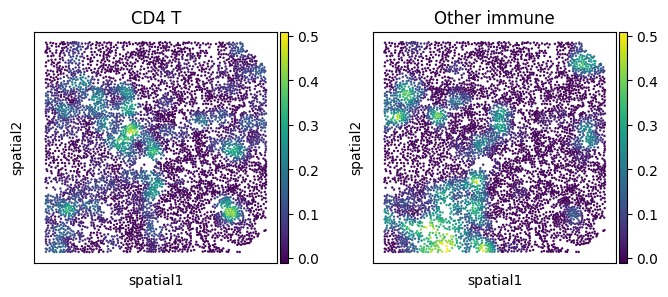

In [5]:
celltype = sorted(adata.obs['all_group_name'].unique())
cn_norm = pd.DataFrame(adata.obsm['X_cn_norm'])
cn_norm.columns = celltype
cn_norm.index = adata.obs.index

# CD4 T and Other immune
adata.obs['CD4 T'] = cn_norm['CD4 T'].copy()
adata.obs['Other immune'] = cn_norm['Other immune'].copy()

sc.pl.embedding(adata[adata.obs['SampleID'] == 9], basis="spatial", color=['CD4 T', 'Other immune'],s=12, show=False, vmax=0.51, vmin=-0.01, )

### Enrichment analysis framework

`scniche` implements a general enrichment analysis framework that can characterize the identified cell niches from various perspectives (including cellular compositions, conditions, and samples, etc.) and compute the corresponding enrichment scores.
We can perform the enrichment analysis from different perspectives by setting the values of the `id_key` and `val_key` parameters. The result is stored in `adata.uns[f"{val_key}_{id_key}_fc"]` and `adata.uns[f"{val_key}_{id_key}_pval"]`.

It is worth noting that the p-value is calculated by the one-sided Mann-Whitney U test.
If the sample size in the dataset is too small (`library_key`),a valid test cannot be implemented.
In this case, we can consider only the enrichment scores and set the parameter `show_pval` to False in the `enrichment_heatmap` function of `scniche` during visualization.

Calculating the enrichment of each cluster (all_group_name) in group (scNiche)...


Cluster: Tumor: 100%|██████████| 13/13 [00:00<00:00, 64.12it/s]


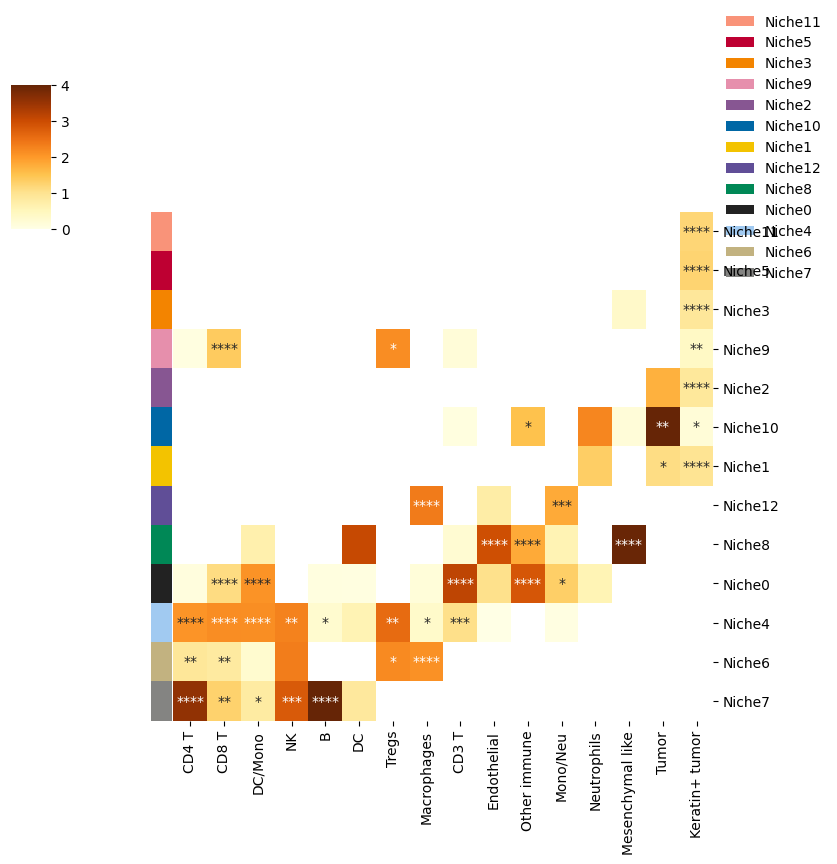

In [6]:
# cell type enrichment
sn.al.enrichment(adata, id_key='all_group_name', val_key='scNiche', library_key='SampleID')

# plot
kwargs = {'figsize': (8, 8), 'vmax': 4, 'cmap': 'YlOrBr', 'linewidths': 0, 'linecolor': 'white', }
col_order = ['CD4 T', 'CD8 T', 'DC/Mono', 'NK', 'B', 'DC', 'Tregs', 'Macrophages', 'CD3 T', 'Endothelial', 'Other immune', 'Mono/Neu', 'Neutrophils', 'Mesenchymal like', 'Tumor', 'Keratin+ tumor', ]
row_order = ['Niche11', 'Niche5', 'Niche3', 'Niche9', 'Niche2', 'Niche10', 'Niche1', 'Niche12', 'Niche8', 'Niche0', 'Niche4', 'Niche6', 'Niche7', ]
adata.uns['scNiche_colors'] = palettes.default_57
colors1 = adata.uns['scNiche_colors']
categories1 = adata.obs['scNiche'].cat.categories
palette_use = [colors1[list(categories1).index(cat)] for cat in row_order]

sn.pl.enrichment_heatmap(adata=adata, id_key='all_group_name', val_key='scNiche', binarized=False, show_pval=True,
                         col_order=col_order, row_order=row_order, anno_key=None, anno_palette=palette_use, kwargs=kwargs)

Calculating the enrichment of each cluster (scNiche) in group (subtype)...


Cluster: Niche9: 100%|██████████| 2/2 [00:00<00:00, 64.65it/s]


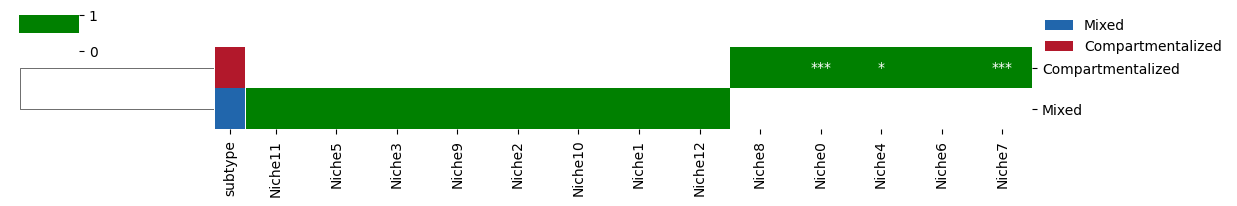

In [7]:
# condition enrichment
sn.al.enrichment(adata, id_key='scNiche', val_key='subtype', library_key='SampleID')

# plot
kwargs = {'figsize': (12, 2),'vmax': 1, 'linewidths': 0, 'linecolor': 'white', }
palette_use = ['#2166AC', '#B2182B', ]
col_order = ['Niche11', 'Niche5', 'Niche3', 'Niche9', 'Niche2', 'Niche10', 'Niche1', 'Niche12', 'Niche8', 'Niche0', 'Niche4', 'Niche6', 'Niche7', ]
sn.pl.enrichment_heatmap(adata=adata, id_key='scNiche', val_key='subtype', anno_palette=palette_use, binarized=True, col_order=col_order, 
                         show_pval=True, anno_key='subtype', kwargs=kwargs)

Calculating the enrichment of each cluster (scNiche) in group (SampleID)...


Cluster: Niche9: 100%|██████████| 34/34 [00:00<00:00, 617.66it/s]


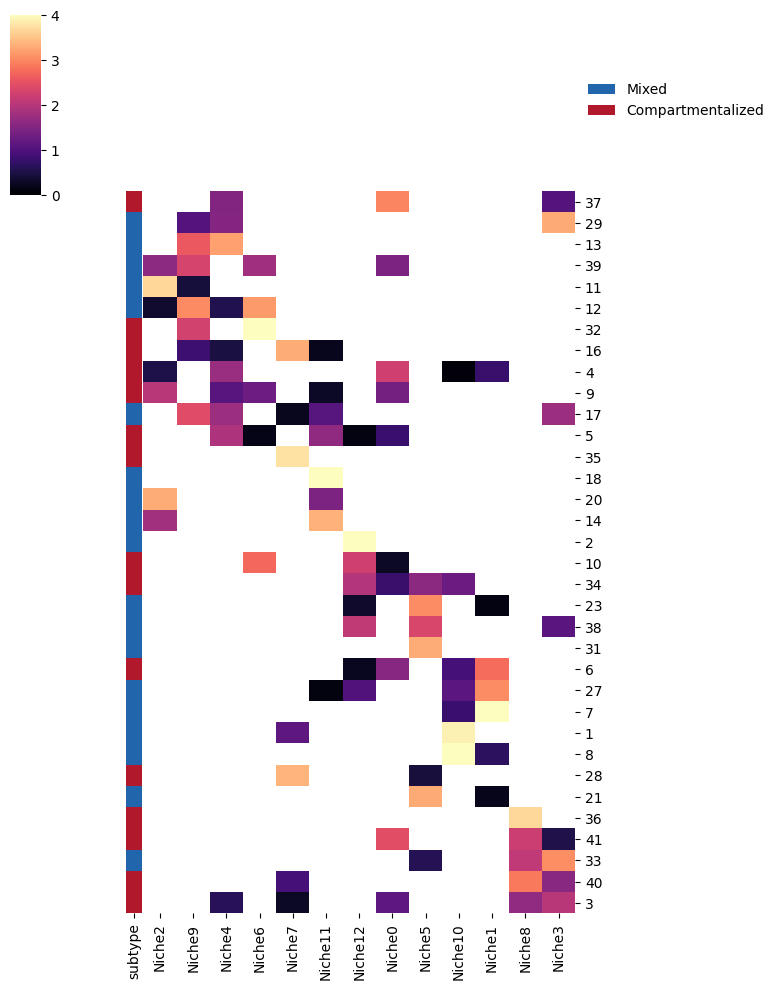

In [8]:
# sample enrichment
sn.al.enrichment(adata, id_key='scNiche', val_key='SampleID', library_key=None)

# plot
kwargs = {'figsize': (6.2, 10), 'vmax': 4, 'cmap': 'magma'}
col_order = ['Niche2', 'Niche9', 'Niche4', 'Niche6', 'Niche7', 'Niche11', 'Niche12', 'Niche0', 'Niche5', 'Niche10', 'Niche1', 'Niche8', 'Niche3', ]
row_order = [37, 29, 13, 39, 11, 12, 32, 16, 4, 9, 17, 5, 35, 18, 20,14, 2, 10,  34,  23, 38, 31,6, 27,7, 1, 8,28, 21,36, 41, 33, 40, 3, ]
palette_use = ['#2166AC', '#B2182B', ]
sn.pl.enrichment_heatmap(adata=adata, id_key='scNiche', val_key='SampleID', binarized=False, col_order=col_order, row_order=row_order, 
                         anno_key='subtype', anno_palette=palette_use, kwargs=kwargs)

We can further extract some cell niches of interest and perform the enrichment analysis again.
In this case, the enrichment scores are calculated among the extracted niches.

This strategy can help us reveal more subtle compositional differences among extracted niches. For example, the enrichment
analysis among extracted 7 tumor-enriched niches reveal the heterogeneity in the type of cells infiltrated and the degree of infiltration.

Calculating the enrichment of each cluster (all_group_name) in group (scNiche)...


Cluster: Tumor: 100%|██████████| 7/7 [00:00<00:00, 64.33it/s]


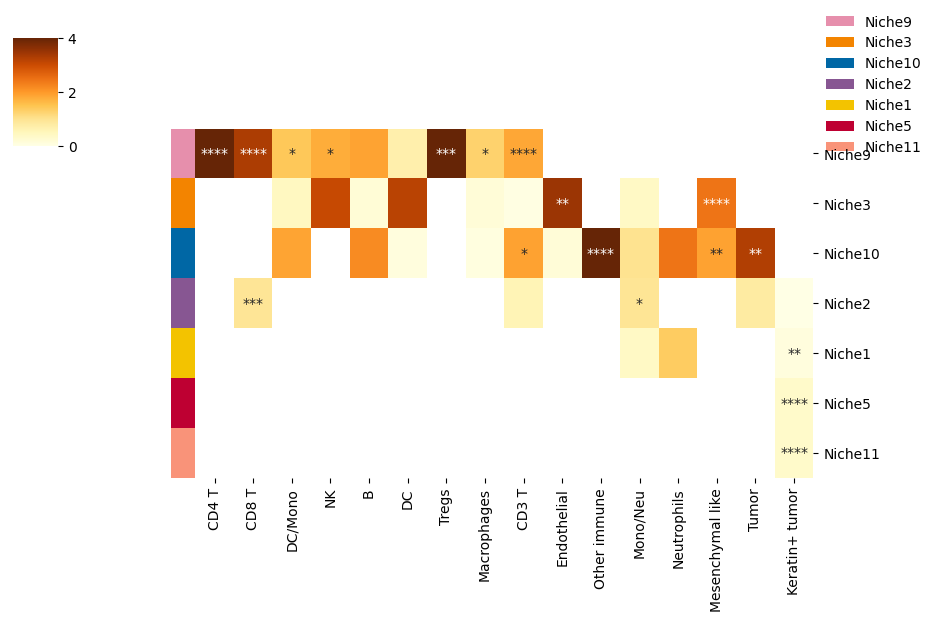

In [9]:
# tumor niches: cell type enrichmant
tumor_list = ['Niche1', 'Niche10', 'Niche2', 'Niche9', 'Niche3', 'Niche5', 'Niche11']
adata_tumor = adata[adata.obs['scNiche'].isin(tumor_list)].copy()
sn.al.enrichment(adata_tumor, id_key='all_group_name', val_key='scNiche', library_key='SampleID')

# plot
kwargs = {'figsize': (9, 6), 'vmax': 4, 'cmap': 'YlOrBr', 'linewidths': 0, 'linecolor': 'white', }
row_order = ['Niche9', 'Niche3', 'Niche10', 'Niche2', 'Niche1', 'Niche5', 'Niche11']
col_order = ['CD4 T', 'CD8 T', 'DC/Mono', 'NK', 'B', 'DC', 'Tregs', 'Macrophages', 'CD3 T', 'Endothelial', 'Other immune', 'Mono/Neu', 'Neutrophils', 'Mesenchymal like', 'Tumor', 'Keratin+ tumor',]
palette_use = [palettes.default_57[i] for i in [9, 3, 10, 2, 1, 5, 11]]
sn.pl.enrichment_heatmap(adata=adata_tumor, id_key='all_group_name', val_key='scNiche', binarized=False, col_order=col_order, row_order=row_order, 
                         anno_key=None, anno_palette=palette_use, show_pval=True, kwargs=kwargs)

### Multi-sample analysis framework

For large-scale datasets containing multiple samples under different conditions, `scniche` implements a multi-sample analysis framework that enables differential analyses at the sample scale,
such as the comparison of specific niches across different conditions, or the comparison of specific cell populations across different niches,
which holds the promise of identifying clinically relevant key niches or cell populations from large-scale datasets while avoiding the influence of individual outliers.

#### Calculate the cellular composition
We can calculate the cellular composition for each niche within each sample by the `calculate_composition_multi` function of `scNiche`,
and the result is stored in `adata.uns["composition_multi"]`.

By default, to avoid the effect of outliers, for each niche, only samples with a proportion of that niche exceeding 5% are considered.
We can set the value of `cutoff` parameter to change the threshold.

In [10]:
library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name'

sn.al.calculate_composition_multi(adata, library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, cutoff=0.05)
adata.uns["composition_multi"].head()

,SampleID,scNiche,Niche_ratio,Keratin+ tumor_ratio,B_ratio,CD3 T_ratio,Macrophages_ratio,Other immune_ratio,DC/Mono_ratio,CD8 T_ratio,CD4 T_ratio,Mesenchymal like_ratio,Endothelial_ratio,Neutrophils_ratio,NK_ratio,Mono/Neu_ratio,Tumor_ratio,DC_ratio,Tregs_ratio
0,1,Niche10,0.737756,0.604073,0.087278,0.067442,0.064798,0.049987,0.040730,0.035176,0.031738,0.008992,0.005290,0.002116,0.001058,0.000793,0.000264,0.000264,NaN
1,1,Niche7,0.188683,0.017580,0.829369,0.023785,0.001034,0.009307,0.004137,0.011375,0.100310,NaN,NaN,NaN,0.002068,NaN,NaN,0.001034,NaN
2,2,Niche12,0.930487,0.621131,0.000711,0.001779,0.178228,0.010672,0.003202,0.077908,0.006403,0.029171,0.031306,0.003557,0.003557,0.018855,0.000356,0.013163,NaN
3,3,Niche3,0.265164,0.869461,0.011976,0.005389,0.023952,0.000599,0.010180,0.011976,0.007186,0.049102,0.006587,0.001198,NaN,NaN,0.001796,0.000599,NaN
4,3,Niche8,0.249762,0.160203,0.047680,0.020979,0.159568,0.064209,0.073109,0.031151,0.032422,0.343293,0.037508,0.003814,0.000636,0.006993,0.001271,0.016529,0.000636


We can visualize the proportion of any cell populations for each niche within each sample by the `multi_boxplot` function of `scniche`.
For example, we found that the proportion of B cells in Niche7 was consistently higher than in other niches across different samples.
This result suggested that Niche7 may represent the tertiary lymphoid structure.

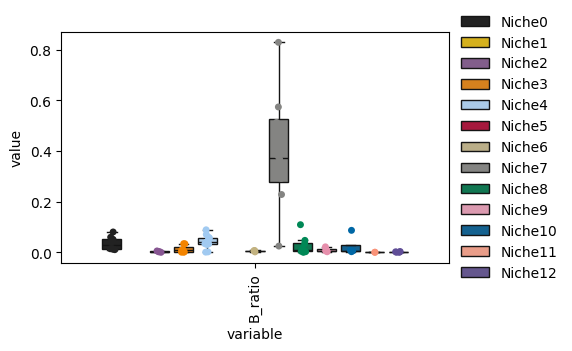

In [11]:
plt.rcParams["figure.figsize"] = (5, 3)
niche_list = ['Niche' + str(i) for i in range(13)]
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=['B', ], mode='composition', show_scatter=True, order=niche_list, palette=palettes.default_57)

Similarly, the proportions of macrophages in Niche6 and Niche12 were consistently higher than in other niches across different samples.

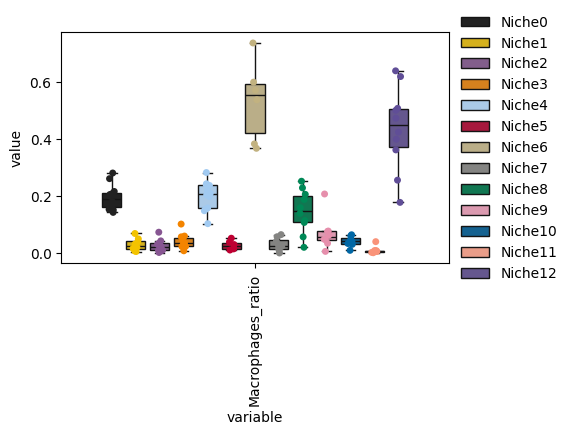

In [12]:
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=['Macrophages', ], mode='composition', show_scatter=True, order=niche_list, palette=palettes.default_57)

We can also visualize only the selected niches by setting the value of `select_niche` parameter, which helps to visually
compare cellular composition between selected niches across samples. For example, for the two macrophage-enriched niches, Niche6 and Niche12,
we found that the macrophages in Niche 6 were likely to exhibit more pronounced spatial proximity to other immune cell types, whereas macrophages in Niche 12 were more likely to co-localize with tumor cells.


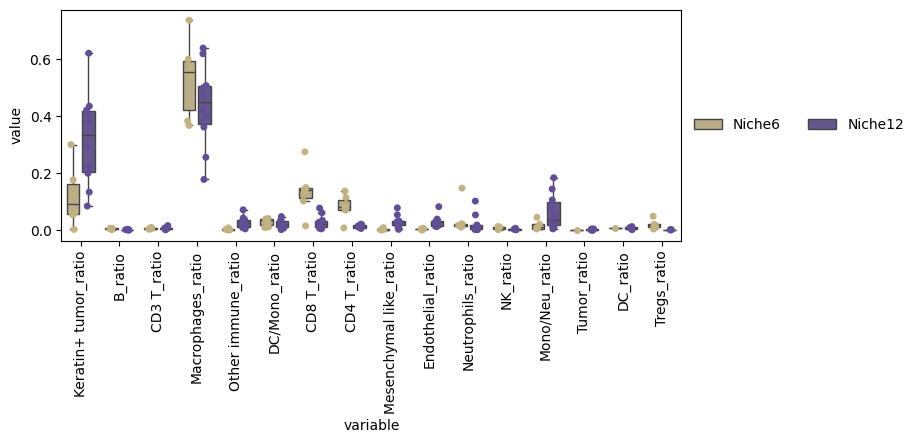

In [13]:
selected_niche = ['Niche6', 'Niche12']
show_list = list(set(adata.obs['all_group_name']))
plt.rcParams["figure.figsize"] = (8, 3)
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=show_list, mode='composition', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[6], palettes.default_57[12]])

The `calculate_composition_multi` function of `scNiche` also calculates the proportion of each niche within each sample.
We can extract the result from `adata.uns['composition_multi']` and visualize it by the heatmap.
For example, we can observe that the two macrophages-enriched niches, Niche6 and Niche12, were mainly present in different TNBC subtypes.

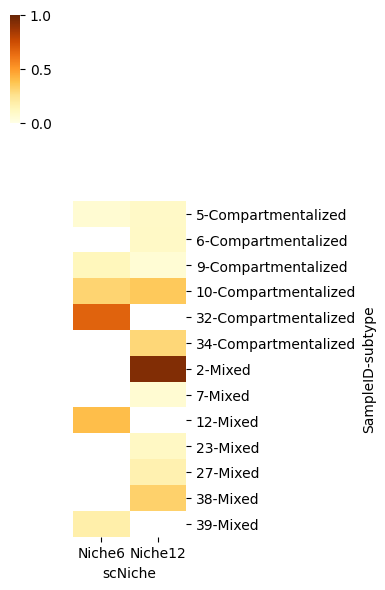

In [14]:
selected_niche = ['Niche6', 'Niche12']
df = adata.uns['composition_multi'].copy()
df = df.loc[df['scNiche'].isin(selected_niche), ['SampleID', 'scNiche', 'Niche_ratio']]
df['subtype'] = np.where(df['SampleID'].isin([34, 36, 6, 40, 5, 41, 10, 3, 9, 32, 4, 28, 37, 16, 35]), 'Compartmentalized', 'Mixed')
df = df.pivot_table(index=['SampleID', 'subtype'], columns='scNiche', values='Niche_ratio', fill_value=np.nan)

# plot
cmap = 'YlOrBr'
cmap = sns.color_palette(cmap, as_cmap=True)
cmap.set_under('white')
order = [5, 6, 9, 10, 32, 34, 2, 7, 12, 23, 27, 38, 39]
sns.clustermap(df.loc[order, selected_niche], xticklabels=True, yticklabels=True, vmax=1, vmin=0, 
               cmap=cmap, linewidths=0, linecolor='white', figsize=(2, 6), row_cluster=False, col_cluster=False)

#### Calculate the phenotypic characteristics
We can calculate the phenotypic characteristics for each niche within each sample by the `calculate_average_exp_multi` function of `scNiche`,
and the result is stored in `adata.uns["expression_multi"]`.

By default, to avoid the effect of outliers, for each niche, only samples with a proportion of that niche exceeding 5% are considered.
We can set the value of `cutoff` parameter to change the threshold. Besides, we can set the value of `selected_celltype` parameter to
calculate the average phenotypic characteristics of all cells belonging to the selected cell populations, otherwise `selected_celltype=None`, `scniche`
will calculate the average phenotypic characteristics of all cells belonging to niches.

In [15]:
library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name'
selected_celltype=['Macrophages']

sn.al.calculate_average_exp_multi(adata, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, 
                                  selected_celltype=selected_celltype, cutoff=0.05)
adata.uns['expression_multi'].head()

,SampleID,scNiche,Niche_ratio,dsDNA,Vimentin,SMA,FoxP3,Lag3,CD4,CD16,...,HLA.DR,CD11b,CD45,H3K9ac,Pan.Keratin,H3K27me3,phospho.S6,MPO,Keratin6,HLA_Class_1
0,1,Niche10,0.737756,-0.481503,-0.765449,-0.250849,-0.076288,-0.086878,-0.316063,-0.249513,...,0.634364,-0.101756,-0.220559,-0.379827,-0.343461,-0.206364,-0.348664,-0.112221,-0.445567,-0.774876
1,1,Niche7,0.188683,-0.078555,-0.821960,-0.377960,-0.076288,-0.086878,-0.143930,-0.355310,...,0.255640,-0.193910,0.471290,0.868560,-0.557660,0.106180,0.203880,-0.139030,-0.527690,-0.514990
2,2,Niche12,0.930487,-0.338718,0.947239,-0.349191,-0.076288,-0.066665,-0.234658,2.431904,...,-0.277247,-0.181060,0.103985,-1.105259,-0.508878,-1.216920,-1.110850,-0.124457,-0.478476,-0.084547
3,3,Niche3,0.265164,-0.177449,1.035604,2.142350,-0.076288,-0.086878,-0.201536,0.469133,...,0.457065,-0.162755,-0.041920,-0.028830,-0.146965,-0.337130,0.302032,-0.139030,-0.400216,-0.095026
4,3,Niche8,0.249762,-0.180091,0.877212,1.258828,-0.076288,-0.086878,-0.291422,0.189845,...,0.475277,-0.164585,-0.110234,0.044847,-0.505655,-0.251740,0.047326,-0.128880,-0.516689,-0.236935


As an example, we further calculated and compared the average phenotypic characteristics of macrophages in Niche6 and Niche12 across samples.
We found that the macrophages in different niches exhibited distinct phenotypes. Specifically, while macrophages within these two niches exhibited consistent expression of classical monocyte markers such as CD68 and CD63, those in Niche 6 also displayed increased expression of both CD11b, CD11c, immune regulation proteins, and antigen presentation proteins, suggesting they were myeloid derived suppressor cells.

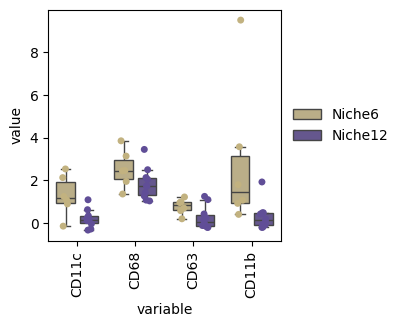

In [16]:
# monocyte_markers
show_genes = ['CD68', 'CD63', 'CD11b', 'CD11c']
selected_niche = ['Niche6', 'Niche12']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[6], palettes.default_57[12]])

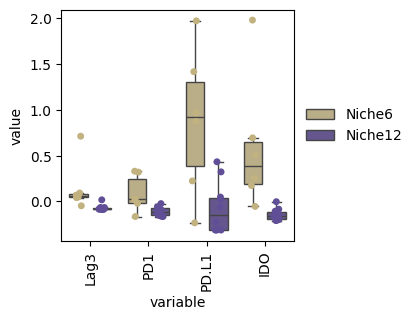

In [17]:
# immune_regulation markers
show_genes = ['IDO', 'Lag3', 'PD1', 'PD.L1']
selected_niche = ['Niche6', 'Niche12']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[6], palettes.default_57[12]])

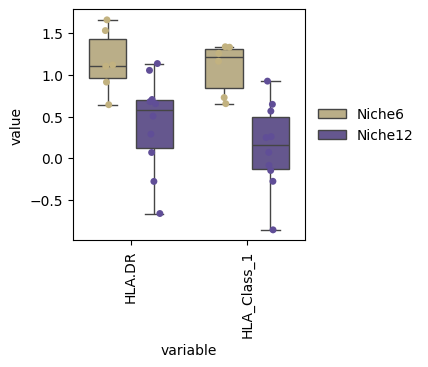

In [18]:
# antigen presentation markers
show_genes = ['HLA_Class_1', 'HLA.DR']
selected_niche = ['Niche6', 'Niche12']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_boxplot(adata=adata, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[6], palettes.default_57[12]])

We can calculate the significance of the phenotypic differences between macrophages located in Niche6 and Niche12 at the sample scales by the two-sided Mann-Whitney U test.

In [19]:
df = adata.uns['expression_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]

from scipy.stats import mannwhitneyu
for gene in ['CD68', 'CD63', 'CD11b', 'CD11c', 'IDO', 'Lag3', 'PD1', 'PD.L1', 'HLA_Class_1', 'HLA.DR', ]:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche6'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Niche12'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")

gene: CD68; pvalue: 0.14710289710289712
gene: CD63; pvalue: 0.07267732267732269
gene: CD11b; pvalue: 0.010989010989010988
gene: CD11c; pvalue: 0.031218781218781223
gene: IDO; pvalue: 0.0004995004995004995
gene: Lag3; pvalue: 0.001932651550825636
gene: PD1; pvalue: 0.02247752247752248
gene: PD.L1; pvalue: 0.015984015984015984
gene: HLA_Class_1; pvalue: 0.000999000999000999
gene: HLA.DR; pvalue: 0.02247752247752248


Visualizing the spatial expression patterns of phenotypic characteristics for each slice

[<AxesSubplot: title={'center': 'CD11b'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'CD11c'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'IDO'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'PD.L1'}, xlabel='spatial1', ylabel='spatial2'>]

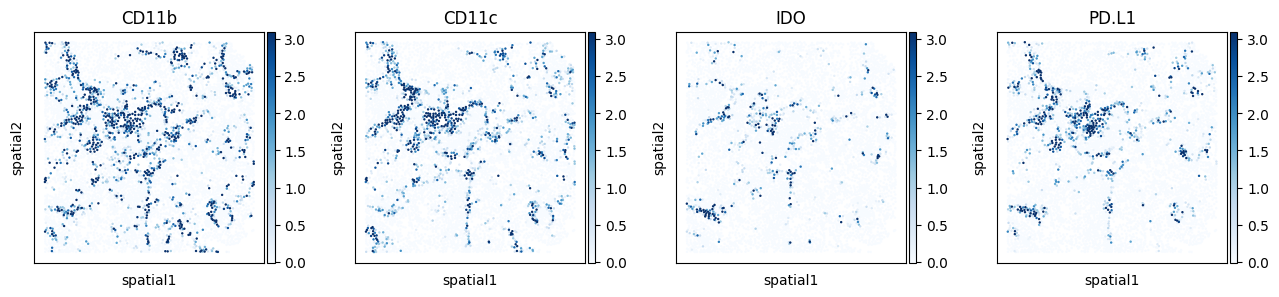

In [20]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata[adata.obs['SampleID'] == 9], basis="spatial", color=['CD11b', 'CD11c', 'IDO', 'PD.L1'],s=12, show=False, vmax=3.1, vmin=-0.01, cmap='Blues')

Similarly, by calculating the average phenotypic characteristics of tumor cells, we found that tumor cells in the
immune-exhausted tumor niches (Niche 5 and Niche 11) exhibited differential expression of the tumor-related proteins, including cytokeratin 6 (CK6) and CK17.

In [21]:
# tumor cells
adata2 = adata.copy()
library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name'
selected_celltype = ['Keratin+ tumor', 'Tumor']

sn.al.calculate_average_exp_multi(adata2, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key,
                                  selected_celltype=selected_celltype, cutoff=0.05)

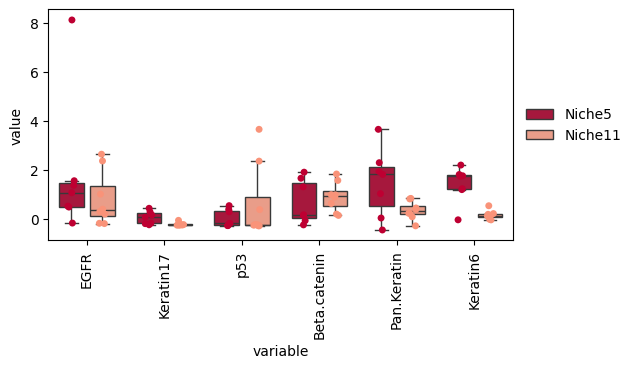

In [22]:
# tumor protein markers
show_genes = ['Beta.catenin', 'p53', 'EGFR', 'Pan.Keratin', 'Keratin6', 'Keratin17', ]
selected_niche = ['Niche5', 'Niche11']
plt.rcParams["figure.figsize"] = (6, 3)
sn.pl.multi_boxplot(adata=adata2, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[5], palettes.default_57[11]])

In [23]:
df = adata2.uns['expression_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]

from scipy.stats import mannwhitneyu
for gene in ['Beta.catenin', 'p53', 'EGFR', 'Pan.Keratin', 'Keratin6', 'Keratin17', ]:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche5'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Niche11'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")

gene: Beta.catenin; pvalue: 0.5358197358197359
gene: p53; pvalue: 0.778865578865579
gene: EGFR; pvalue: 0.280963480963481
gene: Pan.Keratin; pvalue: 0.151981351981352
gene: Keratin6; pvalue: 0.013986013986013986
gene: Keratin17; pvalue: 0.013986013986013986


Additionally, we can reset the category of `scNiche` to other categories of interest, and calculate the cellular composition and phenotypic characteristics again.

For example, compared to other niches, we found that the tumor cells in Niche9 were likely to co-localize with immune cells, and showed increased expression of antigen presentation proteins such as HLA1 and HLA-DR;
the tumor cells in Niche3 were likely to co-localize with stromal cells, and displayed high expression of stromal-related proteins such as SMA and vimentin.

gene: HLA_Class_1; pvalue: 0.005420658052236999
gene: HLA.DR; pvalue: 0.020297853115190577


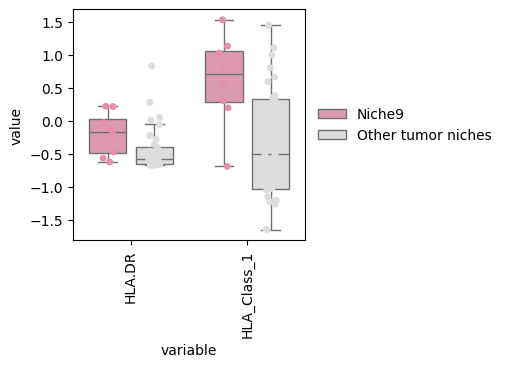

In [24]:
# niche 9
adata3 = adata.copy()
other_tumor_list = ['Niche1', 'Niche10', 'Niche2', 'Niche3', 'Niche5', 'Niche11']
immune_list = ['Niche7', 'Niche6', 'Niche4', 'Niche0', 'Niche8', 'Niche12']
adata3.obs['scNiche'] = adata3.obs['scNiche'].astype('str')
adata3.obs.loc[adata3.obs['scNiche'].isin(other_tumor_list), 'scNiche'] = 'Other tumor niches'
adata3.obs.loc[adata3.obs['scNiche'].isin(immune_list), 'scNiche'] = 'Immune niches'

library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name'
selected_celltype = ['Keratin+ tumor', 'Tumor']

sn.al.calculate_average_exp_multi(adata3, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key,
                                  selected_celltype=selected_celltype, cutoff=0.05)

# antigen_presentation markers
# plot
show_genes = ['HLA_Class_1',  'HLA.DR']
selected_niche = ['Niche9', 'Other tumor niches']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_boxplot(adata=adata3, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[9], '#dcdddd'])

# p-values
df = adata3.uns['expression_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]
from scipy.stats import mannwhitneyu
for gene in ['HLA_Class_1',  'HLA.DR']:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche9'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Other tumor niches'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")

gene: Immune_ratio; pvalue: 8.483228297469784e-05
gene: Stroma_ratio; pvalue: 0.08157045308748097
gene: Tumor_ratio; pvalue: 0.00019067759005839504


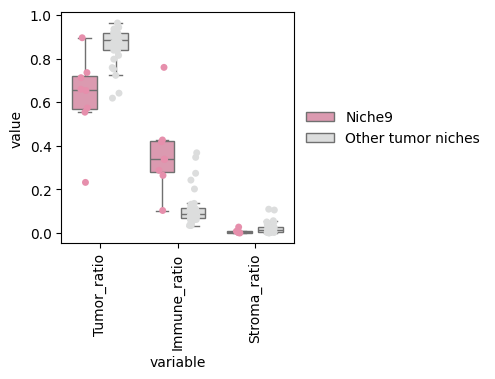

In [25]:
library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name2'
select_niche = ['Niche9', 'Other tumor niches']
show_list = list(set(adata3.obs[celltype_key]))

sn.al.calculate_composition_multi(adata3, library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, cutoff=0.05)

# plot
sn.pl.multi_boxplot(adata=adata3, library_key=library_key, show_list=show_list, mode='composition', show_scatter=True, 
                    select_niche=select_niche, order=select_niche, palette=[palettes.default_57[9], '#dcdddd'])

# p-values
df = adata3.uns['composition_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]
from scipy.stats import mannwhitneyu
for gene in [i + '_ratio' for i in show_list]:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche9'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Other tumor niches'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")

gene: SMA; pvalue: 4.116701201692325e-05
gene: Vimentin; pvalue: 6.219078235128518e-05


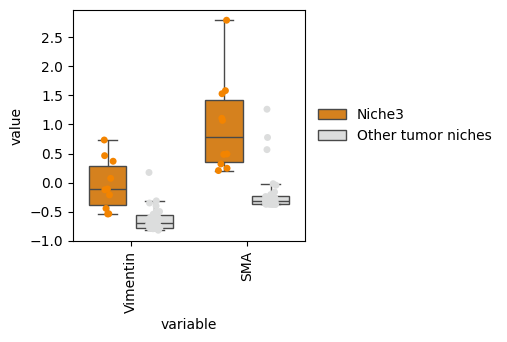

In [26]:
# niche 3
adata4 = adata.copy()
other_tumor_list = ['Niche1', 'Niche10', 'Niche2', 'Niche9', 'Niche5', 'Niche11']
immune_list = ['Niche7', 'Niche6', 'Niche4', 'Niche0', 'Niche8', 'Niche12']
adata4.obs['scNiche'] = adata4.obs['scNiche'].astype('str')
adata4.obs.loc[adata4.obs['scNiche'].isin(other_tumor_list), 'scNiche'] = 'Other tumor niches'
adata4.obs.loc[adata4.obs['scNiche'].isin(immune_list), 'scNiche'] = 'Immune niches'

library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name'
selected_celltype = ['Keratin+ tumor', 'Tumor']

sn.al.calculate_average_exp_multi(adata4, layer_key='data', library_key=library_key, niche_key=niche_key, celltype_key=celltype_key,
                                  selected_celltype=selected_celltype, cutoff=0.05)

# stroma markers
# plot
show_genes = ['SMA', 'Vimentin']
selected_niche = ['Niche3', 'Other tumor niches']
plt.rcParams["figure.figsize"] = (3, 3)
sn.pl.multi_boxplot(adata=adata4, library_key='SampleID', show_list=show_genes, mode='expression', show_scatter=True, 
                    select_niche=selected_niche, order=selected_niche, palette=[palettes.default_57[3], '#dcdddd'])

# p-values
df = adata4.uns['expression_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]
from scipy.stats import mannwhitneyu
for gene in ['SMA', 'Vimentin']:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche3'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Other tumor niches'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")

gene: Immune_ratio; pvalue: 0.23926993677789932
gene: Stroma_ratio; pvalue: 0.0019678987575896807
gene: Tumor_ratio; pvalue: 0.7114727798662875


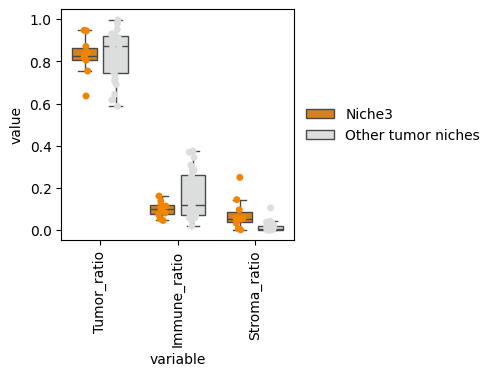

In [27]:
library_key = 'SampleID'
niche_key = 'scNiche'
celltype_key = 'all_group_name2'
select_niche = ['Niche3', 'Other tumor niches']
show_list = list(set(adata4.obs[celltype_key]))
adata4.obs[celltype_key] = adata4.obs[celltype_key].astype('str')

sn.al.calculate_composition_multi(adata4, library_key=library_key, niche_key=niche_key, celltype_key=celltype_key, cutoff=0.05)

# plot
sn.pl.multi_boxplot(adata=adata4, library_key=library_key, show_list=show_list, mode='composition', show_scatter=True, 
                    select_niche=select_niche, order=select_niche, palette=[palettes.default_57[3], '#dcdddd'])

# p-values
df = adata4.uns['composition_multi'].copy()
df = df[df['scNiche'].isin(selected_niche)]
from scipy.stats import mannwhitneyu
for gene in [i + '_ratio' for i in show_list]:
    a = [x for x in df.loc[(df['scNiche'] == 'Niche3'), gene].values if not np.isnan(x)]
    b = [x for x in df.loc[(df['scNiche'] == 'Other tumor niches'), gene].values if not np.isnan(x)]
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(f"gene: {gene}; pvalue: {p}")